# 1. Problem Statement Refinement

The goal of this project is to predict what donation amount to ask of a donor, given a political candidate's description, and the donor's personal information. 

Several factors determine a donor's financial contributions, such as whether the donor has made political donations in the past, what the donor's political leanings are, the candidate's party, the time in the current election cycle, and what office the candidate is running for. 

# 2. EDA Review

Not all donors have the same donation habits. According to the EDA, about 7.9% of total donations come from individuals who donated multiple times; the vast majority only ever make a single political contribution.

Donations tend to spike at regular intervals during election cycles, ie. right before presidential elections. 
<img src='electioncycles.png'>

Highly partisal donors (high or low CF scores) tend to donate more frequently. 
<img src='2024-04-10-191628_677x368_scrot.png'>

Almost all donations for individual donors are under $5000. However, a small number of donations are up to 40 times that amount. We scaled our data by a factor of 5000, as we will only be considering small-dollar donors for this baseline analysis. For now, we are assuming that political campaigns are already familiar with most politically engaged, high net worth individuals.


# 3. Baseline model for first-time donors

We chose the linear regression and tree-based (RandomForestRegressor and GradientBoostingRegressor) model baselines for their simplicity, and to get a ceiling estimate of the error. Our final model will have the goal of improving upon it. 

The training process was to select donor CF scores, candidate CF scores, and election year/month as the predictors, and the scaled donation amount as the response. 

### Preprocessing and Summary statistics

In [1]:
import os
import pandas as pd
from config import DATA_DIR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_all_donors = pd.read_csv(os.path.join(DATA_DIR, 'sample_contributions.csv'))
df = df_all_donors[df_all_donors['Repeat_Donor'] != True]

In [3]:
def simple_preprocessing(df):
    df = df[['scaled_amount', 'date', 'contributor.cfscore', 'candidate.cfscore']].copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    df['contributor.cfscore'].fillna(df['contributor.cfscore'].mean(), inplace=True)
    df['candidate.cfscore'].fillna(df['candidate.cfscore'].mean(), inplace=True)

    #Data is scaled by factor of 5000:1
    print("Scaled maximum:", max(df['scaled_amount']))
    df['amount_capped'] = df['scaled_amount'].apply(lambda x: min(x, 1.0))
    print("Cutoff for small-dollar donors:", max(df['amount_capped']))
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    df.dropna(subset=['date'], inplace=True)

    return df

In [4]:
df = simple_preprocessing(df)

Scaled maximum: 40.0
Cutoff for small-dollar donors: 1.0


Scaled Amount standard deviation: 0.12423210527683524
Scaled Amount mean: 0.07528062489817233


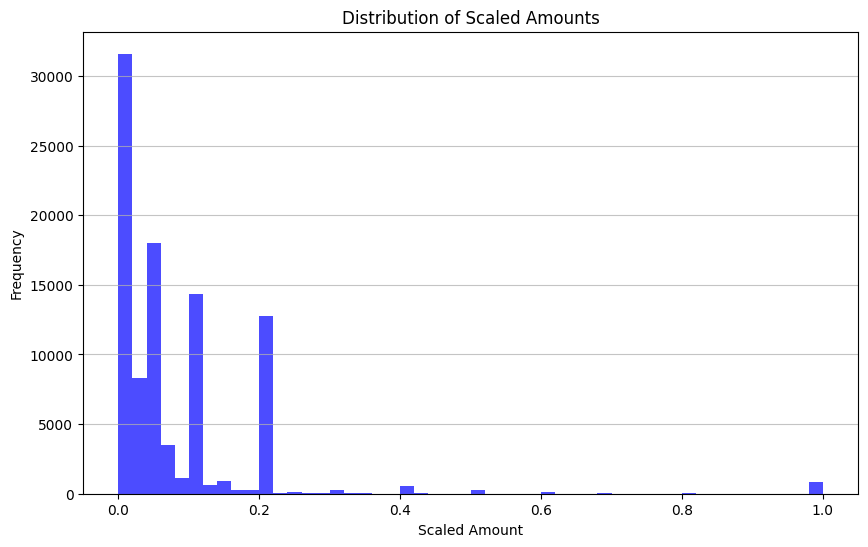

In [8]:
X = df[['contributor.cfscore', 'candidate.cfscore', 'year', 'month']]
y = df['amount_capped']

print("Scaled Amount standard deviation:", np.std(y))
print("Scaled Amount mean:", np.mean(y))

plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, alpha=0.7, color='blue', range=(0, 1))
plt.title('Distribution of Scaled Amounts')
plt.xlabel('Scaled Amount (Capped at 1.0)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

### Linear Regression Baseline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.1227548243902918

### Tree-based Models Baseline

In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_pred, squared=False)

rf_rmse, gb_rmse

(0.12519113234470086, 0.118485920881569)

# 4. Results

Initial results present much room for improvement, as the Gradient Boosting Regressor's RMSE is the lowest (at 0.118), and it is barely lower than the scaled and capped amount's standard deviation (at 0.124).

The Gradient Boosting Regressor model's chief stengths in this case are its ability to handle non-linear relationships between the predictors and responses, and its ability to handle predictor data which vary in type and scaling. The chief weakness is GBR's lack of support for categorical variables that are not ordinal. Therefore, we could not include some predictor variables which would have been useful, such as which office the candidate is running for. 

# 5. Final model outline

We will have two final models. One of which will use a MLP to create a regression for small-dollar, one-time donors, taking into account categorical variables, to overcome the weaknesses of the GBR model described above. The data processing is mostly done for this, we simply need to encode categorical variables, and choose an appropriate architecture. 

The second will allow us to predict what donation to ask of a donor who has made donations in the past. We can potentially implement this with one of two architectures. One approach might be to use a single-directional RNN that treats a frequent donor's order of donation as the time step, and additionally takes the same predictor variables as the one-time donor. 
Another would be to do feature engineering that captures a given frequent donor's entire donation history, so we can eliminate the time series element and use an architecture similar to the one-time donor MLP. This feature engineering could be achieved concatenating past donations and which candidates they went towards into a matrix.

# 6. TF meeting

Daniel Lebedinsky was able to meet with Chris Gumb during office hours on Friday 4/19 to discuss current project state, and incorporated advice for the current milestone.